In [1]:
import torch
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [392]:
# use the GPU instead of CPU

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print("Device:", device)
# torch.set_default_device(device)

# if torch.cuda.is_available():
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

# to reset back to normal
# torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [119]:
# building the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []  # X is the array of the input characters, Y is the output for those input characters

for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', ch)
        context = context[1:] + [ix]  # crop and append for next character's context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [6]:
# building the dataset

def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one?
    X, Y = [], []  # X is the array of the input characters, Y is the output for those input characters
    
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', ch)
            context = context[1:] + [ix]  # crop and append for next character's context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [255]:
n1, n2

(25626, 28829)

In [120]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# in the paper, they have 17,000 words and they embed them in a 30 dimensional space
# in our case, we have 27 possible characters, so we will take something even smaller. let's take 2 for a start
C = torch.randn((27, 2))

In [35]:
# so to embed all the integers in X
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

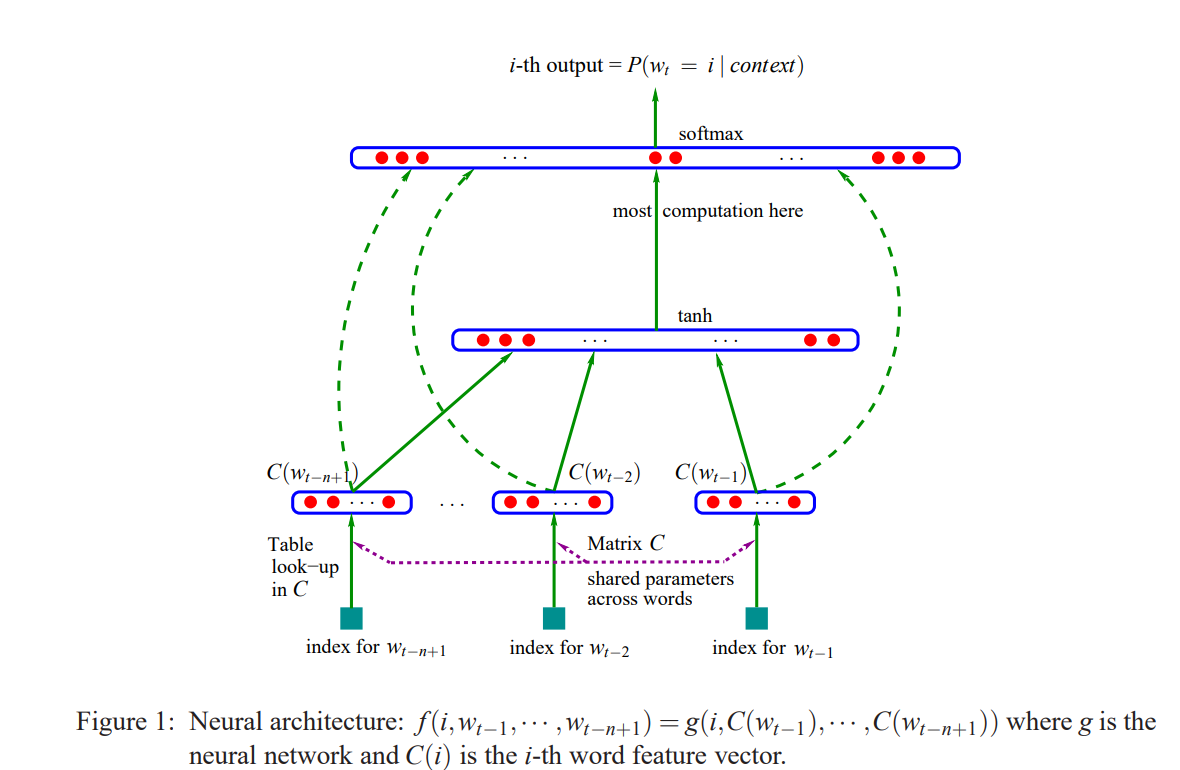

In [36]:
# now for the second layer
W1 = torch.randn((6, 100))   
# the number of inputs to this is going to be 6, 2 each for the 3 letters in context
# the number of neurons is a upto us
b1 = torch.randn(100)

In [77]:
# we would like to but we can't do this directly ---> emb @ W1 + b1
# because of the shape of our tensors don't align for matrix multiplication
# we have emb => [32, 3, 2] and W1 => [6, 100]
# we need to convert the 3, 2 to 6
# one way to do this is by using the view() function like this emb.view(32, -1) or (32, 6)
# The -1 means convert the remaining to array sizes to one single array size
# emb.view(32, 6)

# h = emb.view(32, 6) @ W1 + b1
# h.shape  # 32x6 @ 6x100 => 32x100

# h = emb.view(emb.shape[0], 6) @ W1 + b1  # let's discard 32 for a variable so we can change it later
# or we can do this, PyTorch will figure out that it is 32 or whatever number itself:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # we also tanh here  

In [85]:
h.shape

torch.Size([32, 100])

In [86]:
# final layer

W2 = torch.randn((100, 27))   # input 100, output neurons 27
b2 = torch.randn(27)

In [87]:
logits = h @ W2 + b2  # 32x27

In [98]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()  # nll
loss

tensor(18.6486)

In [100]:
# ---------------- now arranged neatly and all put together ---------------- #

In [73]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [74]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 13), generator=g)
W1 = torch.randn((39, 500), generator=g)   
b1 = torch.randn((500), generator=g)
W2 = torch.randn((500, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [75]:
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)  # number of parameters in total

33878

In [76]:
lri = []
lossi = []
stepi = []

In [77]:
for i in range(200000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (128,))  # generates 32 numbers lying between 0 and X.shape[0]
    
    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 39) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])  # does the older three steps in one and is more efficient 
    # print(loss.item())  # but this is only the loss for that many batch
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else (0.01 if i < 150000 else 0.001)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

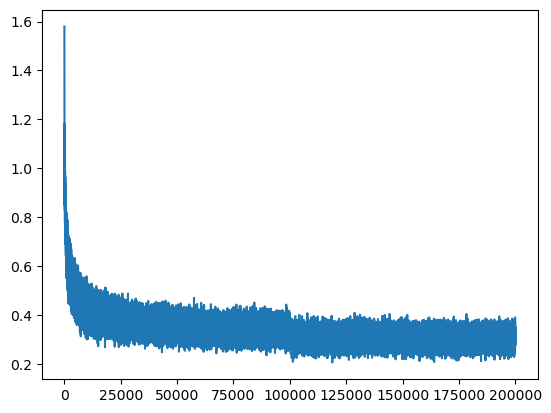

In [78]:
plt.plot(stepi, lossi)

In [79]:
print(loss.item())

2.047032117843628


In [80]:
# train set loss
# for evaluating the full loss

emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 39) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0278, grad_fn=<NllLossBackward0>)

In [81]:
# dev set

emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 39) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

# target to beat: 2.17

tensor(2.1450, grad_fn=<NllLossBackward0>)

In [82]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    block_size = 3
    out = []
    context = [0] * block_size  # initialize with all '...'
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
med.
ryla.
remmadiej.
ramzrudeen.
melin.
shi.
jenne.
elisso.
nar.
kayziah.
kalin.
shubor.
shiriel.
kin.
renleigh.
teron.
urfenden.


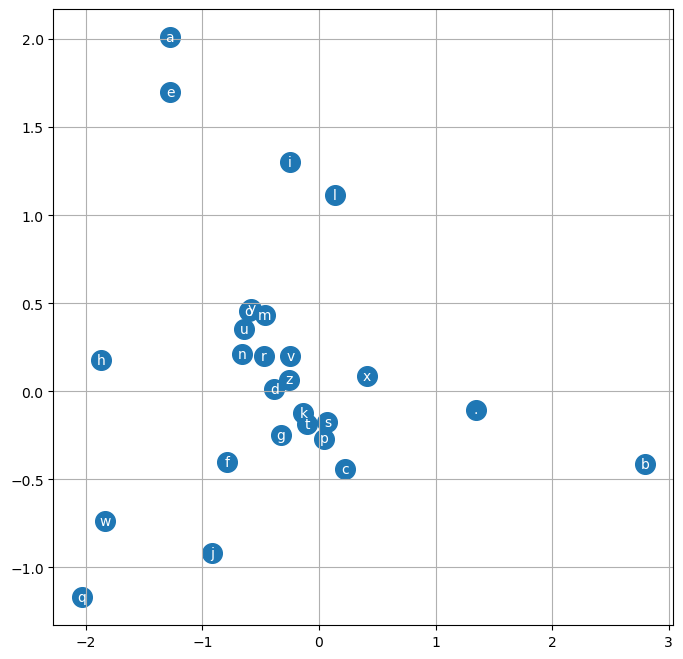

In [72]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid(True)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
# ---------------- some notes and stuff while deriving the network ---------------- #

In [22]:
# this approach is much faster and efficient btw
C[5]  # trying to embed a single integer, by just directly indexing into the lookup table

tensor([ 0.8541, -1.0471])

In [21]:
# another way of doing it is using one hot encoding
F.one_hot(torch.tensor(5), num_classes=27).float()  @ C

# the first argument to one_hot must be a tensor, not an integer
# also, one_hot by default is a int so we need to cast it to a float

tensor([ 0.8541, -1.0471])

In [29]:
# PyTorch allows you to get multiple rows instead of just one by doing C[5] for example, by including a list/tensor containing those indexes
# you can also repeat the same index multiple times to get it multiple times in the output

# C[torch.tensor([5, 6, 7, 7, 7])]
# prints tensor([[ 0.8541, -1.0471],
#        [ 0.9149, -1.7181],
#        [-0.6987,  0.9977],
#        [-0.6987,  0.9977],
#        [-0.6987,  0.9977]])

# you can also index with multi-dimensional tensors of integers
C[X].shape

# C[X].shape
# prints torch.Size([32, 3, 2])
# so for all thirty 'contexts', for each of the three letters they contain, it returns a two dimensional embedding 

# X[13, 2]
# prints tensor(1)  # so the index for character 'a' basically, which is 1

# C[X][13, 2]  # selects the embedding vector from C for 1
# tensor([-1.6568,  0.1407])

# C[1]  # same as the above step
# tensor([-1.6568,  0.1407])

torch.Size([32, 3, 2])

In [54]:
# we would like to but we can't do this directly ---> emb @ W1 + b1
# because of the shape of our tensors don't align for matrix multiplication
# we have emb => [32, 3, 2] and W1 => [6, 100]
# we need to convert the 3, 2 to 6
# one way to do this is by using the view() function like this emb.view(32, -1). 
# The -1 means convert the remaining to array sizes to one single array size
# new_emb = emb.view(32, 6)
# new_emb.shape  # -> torch.Size([32, 6])

# another method to do this (but inefficient)
# emb[:, 0, :].shape  # this plucks out the 32 x 2 embeddings, i.e. embeddings for only the 1st char in all 32 three letter combinations
# torch.Size([32, 2])
# to get all three

# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# to get the embeddings for all three chars in 32 combinations
# and then we combine them to be one
# the 2nd arg 1 is the dimension we want to concatenate them along
# i.e. we want them to be like [embedding for 1st char, embedding for 2nd char, embedding for 3rd char] and like this for each 3 letter combination
# so basically a 1x6 vector, and 32 of those, which makes it 32x6

# another way would be by using the unbind() function
# torch.unbind(emb, 1) where 2nd argument is the dimension we want to remove
# torch.cat(torch.unbind(emb, 1), 1) gives us the same output as the previous one, but this one is more general i.e. it works even if we change block size


torch.Size([32, 2])

In [69]:
# a = torch.arange(18) 
# tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

# a.shape
# torch.Size([18])

a.view(2, 9)  # we can reshape our matrix
a.view(3, 3, 2)  # only condition is they multiply to be the total number of elements, that should remain constant
# view() in PyTorch is extremely efficient

a.storage() --->   
# the storage is all the numbers as a 1 dimensional vector
# this is how the tensor is represented in memory
# when we call view(), the storage is identical, only some of the internal attributes of this tensor are changed
# http://blog.ezyang.com/2019/05/pytorch-internals/
# article on the internals of tensor

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [83]:
# adding the bias

# (emb.view(-1, 6) @ W1).shape
# torch.Size([32, 100])

# b1.shape
# torch.Size([100])

# broadcasting takes place here
# 32, 100
#  1, 100 

In [95]:
torch.arange(32)
# tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# prob[torch.arange(32), Y]  # this gives the current probabilities assigned to the actual correct characters

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()  # nll

# loss = F.cross_entropy(logits, Y)  
# does the previous three steps and is more efficient  
# less intermediate tensors created  
# makes backward pass more efficient

In [132]:
# we are 'overfitting' when we have 32 words in our dataset and ~3500 parameters
# which is why the loss is so low


# take for example the first element, the reason we are not getting it correct is that we have multiple next char predictions for it
# its the '...' sequence (preceding the first letter of a name), for which there are multiple instances in the dataset like e, o, a, i, s
# so it's not able to overfit here

# on the other hand, for a unique character combination, like 'liv' for example, there is only possible answer in the dataset, so here the prediction is accurate

# logits.max(1)
# torch.return_types.max(
# values=tensor([13.4934, 18.1179, 20.7319, 20.8243, 16.9689, 13.4934, 16.2010, 14.3746,
#         16.1040, 18.6489, 16.1952, 21.1680, 13.4934, 17.4009, 17.4007, 20.3321,
#         13.4934, 16.7068, 15.4235, 17.3285, 18.7941, 16.2291, 11.1066, 10.8911,
#         15.6641, 13.4934, 16.4350, 17.1766, 12.8986, 16.3849, 19.3531, 16.3430],
#        grad_fn=<MaxBackward0>),
# indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
#          1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

# Y
# tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
#          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [140]:
torch.randint(0, X.shape[0], (32,))  # generates 32 numbers lying between 0 and X.shape[0]

# we divide our dataset into batches to and train them batch wise instead of the whole at once
# this makes our training faster at the cost of being exact with our gradients
# "it's much better to have an approximate gradient and just make more steps, than it is to evaluate the exact gradient but take fewer steps"

tensor([205594, 188085, 208366, 183299,  53167, 169535,  89438,  53593, 225397,
        194643,  97142, 118092, 180604,  29889, 218351,  65390, 218277, 181096,
         98940, 124588,  32855, 103406, 131054, 116838, 204033,    956, 151885,
        224140,  80749, 172031,  58773,  57150])

In [238]:
# how to determine a learning rate

# we want a varying learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre  # we want exponential steps, not linear

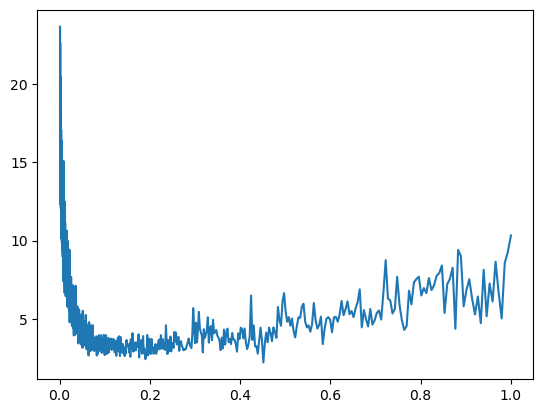

In [227]:
# this is the graph for lr vs loss
# plt.plot(lri, lossi)

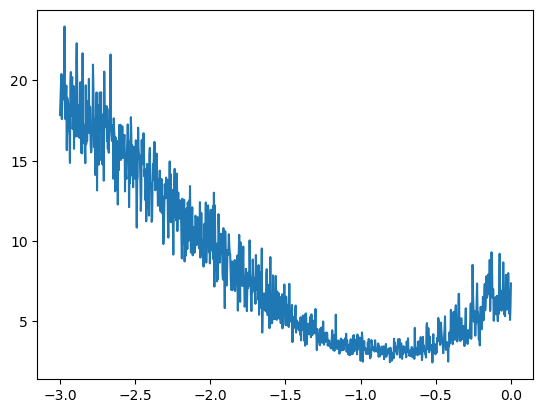

In [235]:
# exponent of the learning rate
plt.plot(lri, lossi)

# so somewhere around -1 as the exponent (i.e. 10^-1) is a a good learning rate

In [ ]:
# learning rate decay
# towards the end of our training, when we decrease the learning rate by 10x

In [275]:
# if our training loss and dev loss are roughly equal, we are 'underfitting'
# so that means our network is too small
# we need to scale up the size of our network

# when our training and dev set loss start to diverge from each other as the parameters are increased, that's how you know you are not underfitting

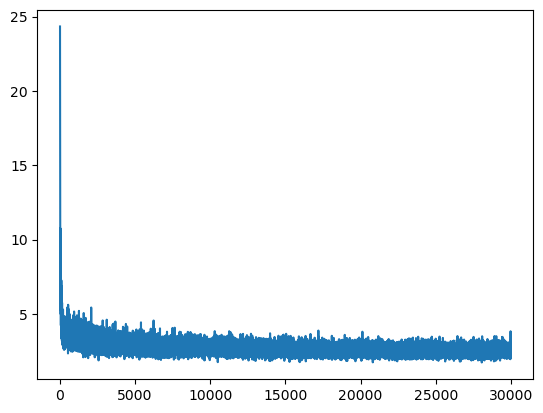

In [280]:
plt.plot(stepi, lossi)  # when we increased the middle layer neurons to 300